In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Week 1

## Intro to NLP

- First step is going to be finding a way to represent text (characters, words, and sentences) as numbers that can be fed into a nueral network.
- Using character level encodings like ASCII lose the semantic value of words. For e.g. LISTEN and SILENT.
- `Word-based encodings`- mapping words to numbers help retain semantic information of words.
- For e.g.
<p style="padding: 10px; border: 2px solid black;">
I love my dog = 1 2 3 4 <br>
I love my cat = 1 2 3 5 <br><br>
=> I=1, love=2, my=3, dog=4, cat=5 <br><br>
[1, 2, 3, 4] and [1, 2, 3, 5] are similar, so just by looking at them we can conclude that the original sentences had to be similar.
</p>

## Word Encodings

**Tensorflow APIs for word encodings**

Tokenizer- generates dictionary of word encodings and creates vectors out of sentences

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

sentences = [
    'I love my dog',
    'I love my cat',
    'You love my dog!'
]

tokenizer = Tokenizer(num_words = 100)
'''
num_words:  maximum number of words minus one (based on frequency)
            to keep when generating sequences
'''

tokenizer.fit_on_texts(sentences) # encodes the data (list of sentences)
word_index = tokenizer.word_index # word_index property returns a dict of word-token pairs

print(word_index)

{'love': 1, 'my': 2, 'i': 3, 'dog': 4, 'cat': 5, 'you': 6}


More frequent words have a lower index.

As we can see, `Tokenizer` ignores case and special symbols. The `lower` and `filter` arguments of Tokenizer override this default behaviour.

In [6]:
tokenizer = Tokenizer(num_words = 1, filters='', lower=False)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
print(word_index)

{'love': 1, 'my': 2, 'I': 3, 'dog': 4, 'cat': 5, 'You': 6, 'dog!': 7}


## Text to sequence

In [7]:
sentences = [
    'I love my dog',
    'I love my cat',
    'You love my dog!',
    'Do you think my dog is amazing?'
]

tokenizer = Tokenizer(num_words = 100)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(sentences)

print(word_index)
print(sequences)

{'my': 1, 'love': 2, 'dog': 3, 'i': 4, 'you': 5, 'cat': 6, 'do': 7, 'think': 8, 'is': 9, 'amazing': 10}
[[4, 2, 1, 3], [4, 2, 1, 6], [5, 2, 1, 3], [7, 5, 8, 1, 3, 9, 10]]


The `text_to_sequences()` method can take in any set of sentences to encode. It will use the word_index it generated during the call to `fit_on_texts()`.

In [8]:
test_data = [
    'i really love my dog',
    'my dog loves my manatee'
]

test_seq = tokenizer.texts_to_sequences(test_data)
print(test_seq) # words not in the word_index will be lost

[[4, 2, 1, 3], [1, 3, 1]]


The `oov_token` argument to Tokenizer ensures that instead of words being ignores, they are replaced by a flag.

In [9]:
sentences = [
    'I love my dog',
    'I love my cat',
    'You love my dog!',
    'Do you think my dog is amazing?'
]

tokenizer = Tokenizer(num_words = 100, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(sentences)

test_data = [
    'i really love my dog',
    'my dog loves my manatee'
]

test_seq = tokenizer.texts_to_sequences(test_data)
print(word_index)
print(test_seq)

{'<OOV>': 1, 'my': 2, 'love': 3, 'dog': 4, 'i': 5, 'you': 6, 'cat': 7, 'do': 8, 'think': 9, 'is': 10, 'amazing': 11}
[[5, 1, 3, 2, 4], [2, 4, 1, 2, 1]]


**Padding**

The lists are of different lengths. Therefore, we need padding so that our inputs to the neurals networks will be of the same shape.

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

sentences = [
    'I love my dog',
    'I love my cat',
    'You love my dog!',
    'Do you think my dog is amazing?'
]

tokenizer = Tokenizer(num_words = 100, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(sentences)

padded = pad_sequences(sequences)
padded_post = pad_sequences(sequences, padding='post', maxlen=5, truncating='pre')

print(word_index)
print(sequences)
print(padded)
print(padded_post)

{'<OOV>': 1, 'my': 2, 'love': 3, 'dog': 4, 'i': 5, 'you': 6, 'cat': 7, 'do': 8, 'think': 9, 'is': 10, 'amazing': 11}
[[5, 3, 2, 4], [5, 3, 2, 7], [6, 3, 2, 4], [8, 6, 9, 2, 4, 10, 11]]
[[ 0  0  0  5  3  2  4]
 [ 0  0  0  5  3  2  7]
 [ 0  0  0  6  3  2  4]
 [ 8  6  9  2  4 10 11]]
[[ 5  3  2  4  0]
 [ 5  3  2  7  0]
 [ 6  3  2  4  0]
 [ 9  2  4 10 11]]


# Week 2

## Word embeddings

Let us represent words as vectors. Similar words point in similar directions and as a result their semantic information is retained.

### The IMDB dataset

- Built in dataset in TFDS (TensorFlow DataSets)

In [11]:
print(tf.__version__)

2.10.0


In [12]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

In [13]:
train_data, test_data = imdb['train'], imdb['test']

In [14]:
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s, l in train_data:
    training_sentences.append(s.numpy().decode('utf8'))
    training_labels.append(l.numpy())
    
# Loop over all test examples and save the sentences and labels
for s, l in test_data:
    testing_sentences.append(s.numpy().decode('utf8'))
    testing_labels.append(l.numpy())

Originally the values were tensors, but since we have been using our Tokenizer on Python lists of numpy arrays, we store them as such using for loops.

In [15]:
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [16]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = "<OOV>"

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

**Creating a Neural Network**

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # Output = 2D array = length of sentence * embedding_dim
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

**Embedding Keras Layer**

Learns vectors so that similar words (w.r.t. label) in the training data are clustered together in an n-dimenstional vector space (where n = embedding_dim).

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In NLP, generally GlobalAveragePooling1D() is used instead of Flatten().

Notice that output shape of Flatten is (None, 1920) while output of GlobalAveragePooling1D is (None, 16) since it averages across the embedding dimensions.

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # Output = 2D array = length of sentence * embedding_dim
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_2 (Dense)             (None, 6)                 102       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
num_epochs = 10
model.fit(padded,
          training_labels_final,
          epochs = num_epochs,
          validation_data = (testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 5s 5ms/step - loss: 0.5958 - accuracy: 0.7003 - val_loss: 0.4761 - val_accuracy: 0.8338
Epoch 2/10
782/782 [==============================] - 4s 5ms/step - loss: 0.4061 - accuracy: 0.8603 - val_loss: 0.3890 - val_accuracy: 0.8559
Epoch 3/10
782/782 [==============================] - 3s 4ms/step - loss: 0.3152 - accuracy: 0.8935 - val_loss: 0.3700 - val_accuracy: 0.8535
Epoch 4/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2611 - accuracy: 0.9125 - val_loss: 0.3711 - val_accuracy: 0.8510
Epoch 5/10
782/782 [==============================] - 4s 5ms/step - loss: 0.2246 - accuracy: 0.9284 - val_loss: 0.3900 - val_accuracy: 0.8444
Epoch 6/10
782/782 [==============================] - 5s 6ms/step - loss: 0.1959 - accuracy: 0.9383 - val_loss: 0.4159 - val_accuracy: 0.8386
Epoch 7/10
782/782 [==============================] - 4s 5ms/step - loss: 0.1755 - accuracy: 0.9463 - val_loss: 0.4464 - val_accuracy: 0.8332
Epoch 

**Visualizing the embeddings**

In [24]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape = (vocab_size, embedding_dim)

(10000, 16)


In [25]:
# Flip the word_index
reverse_word_index = tokenizer.index_word

In [26]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")

out_v.close()
out_m.close()

Visualize these files at https://projector.tensorflow.org

**Why is the validation loss increasing while training loss is decreasing?**

`Think about loss in this context, as a confidence in the prediction. So while the number of accurate predictions increased over time, what was interesting was that the confidence per prediction effectively decreased. You may find this happening a lot with text data. So it's very important to keep an eye on it. One way to do this is to explore the differences as you tweak the hyperparameters. `

### Pre-tokenized datasets

In [27]:
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

In [28]:
tokenizer_subwords = info.features['text'].encoder

### Subword Text Encoder

- `If you want the tokenizer above to not have OOVs, then the vocab_size will increase to more than 88k. This can slow down training and bloat the model size. The encoder also won't be robust when used on other datasets which may contain new words, thus resulting in OOVs again.`

- `Subword text encoding gets around this problem by using parts of the word to compose whole words. This makes it more flexible when it encounters uncommon words.`

- `Subword encoding can even perform well on words that are not commonly found on movie reviews.`

In [29]:
print(tokenizer_subwords.subwords[:20])

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_']


In [30]:
sample_string = "Tensorflow, from basics to mastery"

tokenized_string = tokenizer_subwords.encode(sample_string)
print(f'Tokenized string is {tokenized_string}')

original_string = tokenizer_subwords.decode(tokenized_string)
print(f'The original string: {original_string}')

Tokenized string is [6307, 2327, 2934, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: Tensorflow, from basics to mastery


In [31]:
for ts in tokenized_string:
    print(f"{ts} ----> {tokenizer_subwords.decode([ts])}")

6307 ----> Ten
2327 ----> sor
2934 ----> flow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


Note that it is case sensitive and the punctuation is maintained as well.

- `Sub-word meanings are often nonsensical and it's only when we put them together in sequences that they have meaningful semantics. Thus, some way from learning from sequences would be a great way forward --> RNNs`

- `Subword text encoding can be a robust technique to avoid out-of-vocabulary tokens. It can decode uncommon words it hasn't seen before even with a relatively small vocab size. Consequently, it results in longer token sequences when compared to full word tokenization.`

# Week 3

## Sequential Models

### RNNs

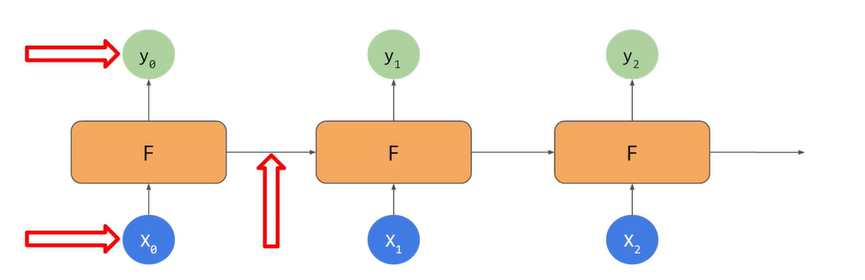

We have `x` as input and `y` as an output. But there's also an element that's fed into the function from a previous function.

### LSTMs

- Take the sentence: "I lived in Ireland, so at school they made me learn to to speak ______".
- Correct answer: I lived in Ireland, so at school they made me learn to to speak `Gaelic`.
- The keyword to determine the answer `Gaelic` is `Ireland`, which occurs much earlier in the sentence. In normal RNNs, we might lose this context as we move along the network. Enter LSTMs.
- LSTM (Long Short Term Memory) have an additional pipeline called Cell State that is passed through the network. It can also be bidirectional.

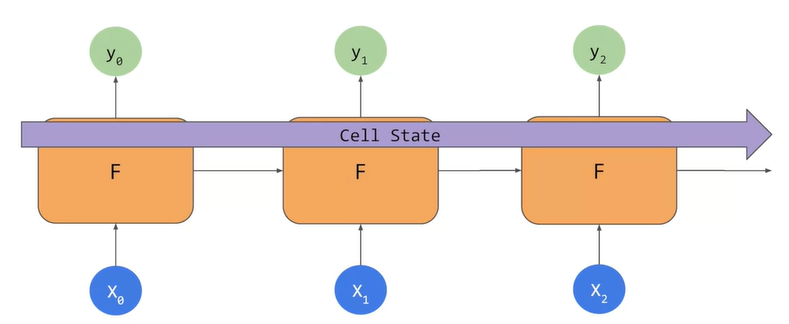

**LSTMs in Code**

In [32]:
vocab_size = 8185
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)

In [33]:
tokenizer

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.num_words, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          523840    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


Can also stack LSTMs like normal Keras Layers:

In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.num_words, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    # When stacking, set return_sequences=True
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [37]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          523840    
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 635,329
Trainable params: 635,329
Non-tr

 **Jaggedness can be an indication that your model needs improvement.**

### Convolutional Network

- For temporal data such as text sequences, we use Conv1D instead of Conv2D so the convolution will happen over a single dimension. We also append a pooling layer to reduce the output of the convolution layer.
- We can use GlobalMaxPooling1D to get the max value across the time dimension. We can also use average pooling.

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'), # filter=128, filter size=5 words
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [39]:
model.summary()
# 120 words, filter of size 5 will remove 2 words from front and back ---> 116 words

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 16)           130960    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_8 (Dense)             (None, 24)                3096      
                                                                 
 dense_9 (Dense)             (None, 1)                 25        
                                                                 
Total params: 144,449
Trainable params: 144,449
Non-trainable params: 0
________________________________________________

### GRUs

In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [41]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 120, 16)           130960    
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 6)                 390       
                                                                 
 dense_11 (Dense)            (None, 1)                 7         
                                                                 
Total params: 140,957
Trainable params: 140,957
Non-trainable params: 0
_________________________________________________________________


# Week 4

## Text Generation

- Think in terms of text prediction. Consider a task X -> Y (output) where X = "Twinkle Twinkle Little" and Y(target) = Star

In [42]:
text = '''
In the town of Athy one Jeremy Lanigan
Battered away till he hadn't a shilling
His father he died and made him a man again
Left him a farm and ten acres of ground

He threw a grand party to friends and relations
Who didn't forget him when come to the wall
And if you but listen, I'll make your eyes glisten
At the rows and the ructions of Lanigan's Ball


Meself to be sure got free invitations
For all the nice girls and boys I might ask
And just in minute both friends and relations
Were dancing like bees around a sweet cask

Miss Judy O'Daly that nice little milliner
Tipped me a wink for to give her a call
And soon I arrived with Peggy McGilligan
Just in time for Lanigan's ball
'''

In [45]:
tokenizer = Tokenizer()

data = text
corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1 # Adding 1 to consider words that are OOV

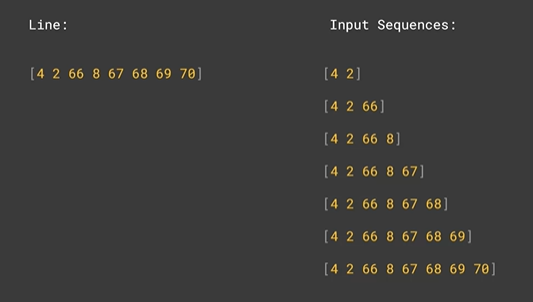

In [47]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])

input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
# Padding is pre so it's easier to extract labels from the end

In [48]:
xs = input_sequences[:, :-1]
labels = input_sequences[:, -1]

# one-hot encode for y
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words) # total_words is # of words in corpus

In [52]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(total_words, 64, input_length=max_sequence_len - 1)) # subtract 1 as we used last label as Y
model.add((tf.keras.layers.LSTM(20)))
model.add(tf.keras.layers.Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(xs, ys, epochs=500, verbose=1)

Epoch 1/500
4/4 [==============================] - 1s 6ms/step - loss: 4.5741 - accuracy: 0.0169
Epoch 2/500
4/4 [==============================] - 0s 6ms/step - loss: 4.5675 - accuracy: 0.0593
Epoch 3/500
4/4 [==============================] - 0s 5ms/step - loss: 4.5619 - accuracy: 0.0763
Epoch 4/500
4/4 [==============================] - 0s 6ms/step - loss: 4.5560 - accuracy: 0.0763
Epoch 5/500
4/4 [==============================] - 0s 6ms/step - loss: 4.5491 - accuracy: 0.0847
Epoch 6/500
4/4 [==============================] - 0s 7ms/step - loss: 4.5413 - accuracy: 0.0763
Epoch 7/500
4/4 [==============================] - 0s 6ms/step - loss: 4.5321 - accuracy: 0.0763
Epoch 8/500
4/4 [==============================] - 0s 7ms/step - loss: 4.5210 - accuracy: 0.0593
Epoch 9/500
4/4 [==============================] - 0s 6ms/step - loss: 4.5074 - accuracy: 0.0508
Epoch 10/500
4/4 [==============================] - 0s 5ms/step - loss: 4.4896 - accuracy: 0.0593
Epoch 11/500
4/4 [===========

4/4 [==============================] - 0s 5ms/step - loss: 2.7414 - accuracy: 0.3136
Epoch 85/500
4/4 [==============================] - 0s 5ms/step - loss: 2.7245 - accuracy: 0.3475
Epoch 86/500
4/4 [==============================] - 0s 5ms/step - loss: 2.7067 - accuracy: 0.3475
Epoch 87/500
4/4 [==============================] - 0s 5ms/step - loss: 2.6906 - accuracy: 0.3390
Epoch 88/500
4/4 [==============================] - 0s 6ms/step - loss: 2.6745 - accuracy: 0.3559
Epoch 89/500
4/4 [==============================] - 0s 5ms/step - loss: 2.6588 - accuracy: 0.3305
Epoch 90/500
4/4 [==============================] - 0s 4ms/step - loss: 2.6438 - accuracy: 0.3475
Epoch 91/500
4/4 [==============================] - 0s 5ms/step - loss: 2.6285 - accuracy: 0.3644
Epoch 92/500
4/4 [==============================] - 0s 4ms/step - loss: 2.6114 - accuracy: 0.3644
Epoch 93/500
4/4 [==============================] - 0s 2ms/step - loss: 2.5992 - accuracy: 0.3559
Epoch 94/500
4/4 [===============

4/4 [==============================] - 0s 4ms/step - loss: 1.7372 - accuracy: 0.6271
Epoch 168/500
4/4 [==============================] - 0s 5ms/step - loss: 1.7257 - accuracy: 0.6695
Epoch 169/500
4/4 [==============================] - 0s 5ms/step - loss: 1.7160 - accuracy: 0.6271
Epoch 170/500
4/4 [==============================] - 0s 7ms/step - loss: 1.7062 - accuracy: 0.6525
Epoch 171/500
4/4 [==============================] - 0s 5ms/step - loss: 1.7000 - accuracy: 0.6525
Epoch 172/500
4/4 [==============================] - 0s 5ms/step - loss: 1.6933 - accuracy: 0.6949
Epoch 173/500
4/4 [==============================] - 0s 571us/step - loss: 1.6843 - accuracy: 0.6525
Epoch 174/500
4/4 [==============================] - 0s 5ms/step - loss: 1.6679 - accuracy: 0.6610
Epoch 175/500
4/4 [==============================] - 0s 2ms/step - loss: 1.6623 - accuracy: 0.7119
Epoch 176/500
4/4 [==============================] - 0s 5ms/step - loss: 1.6527 - accuracy: 0.6525
Epoch 177/500
4/4 [===

4/4 [==============================] - 0s 10ms/step - loss: 1.1191 - accuracy: 0.8475
Epoch 250/500
4/4 [==============================] - 0s 6ms/step - loss: 1.1149 - accuracy: 0.8559
Epoch 251/500
4/4 [==============================] - 0s 4ms/step - loss: 1.1072 - accuracy: 0.8559
Epoch 252/500
4/4 [==============================] - 0s 2ms/step - loss: 1.1010 - accuracy: 0.8559
Epoch 253/500
4/4 [==============================] - 0s 4ms/step - loss: 1.0947 - accuracy: 0.8644
Epoch 254/500
4/4 [==============================] - 0s 3ms/step - loss: 1.0895 - accuracy: 0.8644
Epoch 255/500
4/4 [==============================] - 0s 5ms/step - loss: 1.0842 - accuracy: 0.8559
Epoch 256/500
4/4 [==============================] - 0s 3ms/step - loss: 1.0780 - accuracy: 0.8644
Epoch 257/500
4/4 [==============================] - 0s 2ms/step - loss: 1.0728 - accuracy: 0.8644
Epoch 258/500
4/4 [==============================] - 0s 5ms/step - loss: 1.0659 - accuracy: 0.8559
Epoch 259/500
4/4 [====

4/4 [==============================] - 0s 5ms/step - loss: 0.7321 - accuracy: 0.9576
Epoch 332/500
4/4 [==============================] - 0s 6ms/step - loss: 0.7282 - accuracy: 0.9576
Epoch 333/500
4/4 [==============================] - 0s 6ms/step - loss: 0.7252 - accuracy: 0.9576
Epoch 334/500
4/4 [==============================] - 0s 5ms/step - loss: 0.7212 - accuracy: 0.9492
Epoch 335/500
4/4 [==============================] - 0s 9ms/step - loss: 0.7177 - accuracy: 0.9576
Epoch 336/500
4/4 [==============================] - 0s 5ms/step - loss: 0.7157 - accuracy: 0.9576
Epoch 337/500
4/4 [==============================] - 0s 2ms/step - loss: 0.7104 - accuracy: 0.9576
Epoch 338/500
4/4 [==============================] - 0s 5ms/step - loss: 0.7062 - accuracy: 0.9576
Epoch 339/500
4/4 [==============================] - 0s 4ms/step - loss: 0.7026 - accuracy: 0.9576
Epoch 340/500
4/4 [==============================] - 0s 5ms/step - loss: 0.6990 - accuracy: 0.9576
Epoch 341/500
4/4 [=====

4/4 [==============================] - 0s 5ms/step - loss: 0.4967 - accuracy: 0.9746
Epoch 414/500
4/4 [==============================] - 0s 4ms/step - loss: 0.4955 - accuracy: 0.9746
Epoch 415/500
4/4 [==============================] - 0s 5ms/step - loss: 0.4928 - accuracy: 0.9661
Epoch 416/500
4/4 [==============================] - 0s 4ms/step - loss: 0.4902 - accuracy: 0.9661
Epoch 417/500
4/4 [==============================] - 0s 5ms/step - loss: 0.4881 - accuracy: 0.9661
Epoch 418/500
4/4 [==============================] - 0s 5ms/step - loss: 0.4862 - accuracy: 0.9661
Epoch 419/500
4/4 [==============================] - 0s 3ms/step - loss: 0.4844 - accuracy: 0.9661
Epoch 420/500
4/4 [==============================] - 0s 5ms/step - loss: 0.4831 - accuracy: 0.9746
Epoch 421/500
4/4 [==============================] - 0s 4ms/step - loss: 0.4804 - accuracy: 0.9661
Epoch 422/500
4/4 [==============================] - 0s 5ms/step - loss: 0.4794 - accuracy: 0.9746
Epoch 423/500
4/4 [=====

4/4 [==============================] - 0s 5ms/step - loss: 0.3522 - accuracy: 0.9746
Epoch 496/500
4/4 [==============================] - 0s 5ms/step - loss: 0.3506 - accuracy: 0.9831
Epoch 497/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3490 - accuracy: 0.9831
Epoch 498/500
4/4 [==============================] - 0s 5ms/step - loss: 0.3474 - accuracy: 0.9831
Epoch 499/500
4/4 [==============================] - 0s 6ms/step - loss: 0.3452 - accuracy: 0.9831
Epoch 500/500
4/4 [==============================] - 0s 5ms/step - loss: 0.3444 - accuracy: 0.9831


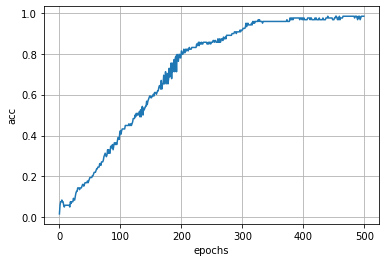

In [57]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.ylabel("acc")
plt.xlabel("epochs")
plt.grid(True)

**Making predictions with the model**

In [62]:
seed_text = "Laurence went to dublin"
next_words = 10

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

    predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
    output_word = tokenizer.index_word[int(predicted)]
    
    seed_text += " " + output_word

print(seed_text)

Laurence went to dublin to to the sure got free invitations invitations invitations invitations


There's a lot of repetition of words in the prediction. This is because the network is only looking forward. We can fix this by making the LSTM layer bidirectional.

In [63]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(total_words, 64, input_length=max_sequence_len - 1)) # subtract 1 as we used last label as Y
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)))
model.add(tf.keras.layers.Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(xs, ys, epochs=500, verbose=1)

Epoch 1/500
4/4 [==============================] - 2s 8ms/step - loss: 4.5737 - accuracy: 0.0169
Epoch 2/500
4/4 [==============================] - 0s 8ms/step - loss: 4.5656 - accuracy: 0.0593
Epoch 3/500
4/4 [==============================] - 0s 8ms/step - loss: 4.5585 - accuracy: 0.0847
Epoch 4/500
4/4 [==============================] - 0s 7ms/step - loss: 4.5507 - accuracy: 0.0847
Epoch 5/500
4/4 [==============================] - 0s 8ms/step - loss: 4.5427 - accuracy: 0.0763
Epoch 6/500
4/4 [==============================] - 0s 7ms/step - loss: 4.5324 - accuracy: 0.0763
Epoch 7/500
4/4 [==============================] - 0s 7ms/step - loss: 4.5214 - accuracy: 0.0678
Epoch 8/500
4/4 [==============================] - 0s 7ms/step - loss: 4.5071 - accuracy: 0.0678
Epoch 9/500
4/4 [==============================] - 0s 7ms/step - loss: 4.4880 - accuracy: 0.0678
Epoch 10/500
4/4 [==============================] - 0s 7ms/step - loss: 4.4657 - accuracy: 0.0678
Epoch 11/500
4/4 [===========

4/4 [==============================] - 0s 7ms/step - loss: 1.8038 - accuracy: 0.6525
Epoch 85/500
4/4 [==============================] - 0s 7ms/step - loss: 1.7792 - accuracy: 0.6949
Epoch 86/500
4/4 [==============================] - 0s 7ms/step - loss: 1.7584 - accuracy: 0.6949
Epoch 87/500
4/4 [==============================] - 0s 7ms/step - loss: 1.7397 - accuracy: 0.6949
Epoch 88/500
4/4 [==============================] - 0s 7ms/step - loss: 1.7200 - accuracy: 0.7203
Epoch 89/500
4/4 [==============================] - 0s 8ms/step - loss: 1.7092 - accuracy: 0.7119
Epoch 90/500
4/4 [==============================] - 0s 8ms/step - loss: 1.6879 - accuracy: 0.7203
Epoch 91/500
4/4 [==============================] - 0s 8ms/step - loss: 1.6682 - accuracy: 0.7034
Epoch 92/500
4/4 [==============================] - 0s 7ms/step - loss: 1.6443 - accuracy: 0.7373
Epoch 93/500
4/4 [==============================] - 0s 7ms/step - loss: 1.6229 - accuracy: 0.7288
Epoch 94/500
4/4 [===============

4/4 [==============================] - 0s 9ms/step - loss: 0.8396 - accuracy: 0.8983
Epoch 168/500
4/4 [==============================] - 0s 8ms/step - loss: 0.8324 - accuracy: 0.8814
Epoch 169/500
4/4 [==============================] - 0s 7ms/step - loss: 0.8258 - accuracy: 0.8898
Epoch 170/500
4/4 [==============================] - 0s 8ms/step - loss: 0.8204 - accuracy: 0.8898
Epoch 171/500
4/4 [==============================] - 0s 6ms/step - loss: 0.8124 - accuracy: 0.8898
Epoch 172/500
4/4 [==============================] - 0s 7ms/step - loss: 0.8102 - accuracy: 0.8814
Epoch 173/500
4/4 [==============================] - 0s 6ms/step - loss: 0.8064 - accuracy: 0.9153
Epoch 174/500
4/4 [==============================] - 0s 7ms/step - loss: 0.7986 - accuracy: 0.8898
Epoch 175/500
4/4 [==============================] - 0s 7ms/step - loss: 0.7914 - accuracy: 0.8898
Epoch 176/500
4/4 [==============================] - 0s 6ms/step - loss: 0.7849 - accuracy: 0.9153
Epoch 177/500
4/4 [=====

4/4 [==============================] - 0s 7ms/step - loss: 0.4586 - accuracy: 0.9661
Epoch 250/500
4/4 [==============================] - 0s 7ms/step - loss: 0.4553 - accuracy: 0.9661
Epoch 251/500
4/4 [==============================] - 0s 7ms/step - loss: 0.4521 - accuracy: 0.9661
Epoch 252/500
4/4 [==============================] - 0s 7ms/step - loss: 0.4502 - accuracy: 0.9661
Epoch 253/500
4/4 [==============================] - 0s 8ms/step - loss: 0.4480 - accuracy: 0.9661
Epoch 254/500
4/4 [==============================] - 0s 8ms/step - loss: 0.4465 - accuracy: 0.9576
Epoch 255/500
4/4 [==============================] - 0s 8ms/step - loss: 0.4429 - accuracy: 0.9661
Epoch 256/500
4/4 [==============================] - 0s 7ms/step - loss: 0.4377 - accuracy: 0.9661
Epoch 257/500
4/4 [==============================] - 0s 6ms/step - loss: 0.4348 - accuracy: 0.9661
Epoch 258/500
4/4 [==============================] - 0s 7ms/step - loss: 0.4327 - accuracy: 0.9661
Epoch 259/500
4/4 [=====

4/4 [==============================] - 0s 8ms/step - loss: 0.2730 - accuracy: 0.9831
Epoch 332/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2739 - accuracy: 0.9831
Epoch 333/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2743 - accuracy: 0.9831
Epoch 334/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2706 - accuracy: 0.9831
Epoch 335/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2688 - accuracy: 0.9831
Epoch 336/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2669 - accuracy: 0.9831
Epoch 337/500
4/4 [==============================] - 0s 8ms/step - loss: 0.2651 - accuracy: 0.9831
Epoch 338/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2638 - accuracy: 0.9831
Epoch 339/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2626 - accuracy: 0.9746
Epoch 340/500
4/4 [==============================] - 0s 7ms/step - loss: 0.2612 - accuracy: 0.9831
Epoch 341/500
4/4 [=====

4/4 [==============================] - 0s 8ms/step - loss: 0.1708 - accuracy: 0.9831
Epoch 414/500
4/4 [==============================] - 0s 5ms/step - loss: 0.1697 - accuracy: 0.9831
Epoch 415/500
4/4 [==============================] - 0s 6ms/step - loss: 0.1681 - accuracy: 0.9746
Epoch 416/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1671 - accuracy: 0.9831
Epoch 417/500
4/4 [==============================] - 0s 8ms/step - loss: 0.1657 - accuracy: 0.9831
Epoch 418/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1650 - accuracy: 0.9831
Epoch 419/500
4/4 [==============================] - 0s 6ms/step - loss: 0.1639 - accuracy: 0.9831
Epoch 420/500
4/4 [==============================] - 0s 8ms/step - loss: 0.1637 - accuracy: 0.9746
Epoch 421/500
4/4 [==============================] - 0s 8ms/step - loss: 0.1626 - accuracy: 0.9831
Epoch 422/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1615 - accuracy: 0.9831
Epoch 423/500
4/4 [=====

4/4 [==============================] - 0s 5ms/step - loss: 0.1146 - accuracy: 0.9831
Epoch 496/500
4/4 [==============================] - 0s 6ms/step - loss: 0.1143 - accuracy: 0.9831
Epoch 497/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1138 - accuracy: 0.9831
Epoch 498/500
4/4 [==============================] - 0s 7ms/step - loss: 0.1132 - accuracy: 0.9831
Epoch 499/500
4/4 [==============================] - 0s 5ms/step - loss: 0.1128 - accuracy: 0.9831
Epoch 500/500
4/4 [==============================] - 0s 6ms/step - loss: 0.1124 - accuracy: 0.9831


The network converges a bit quicker.

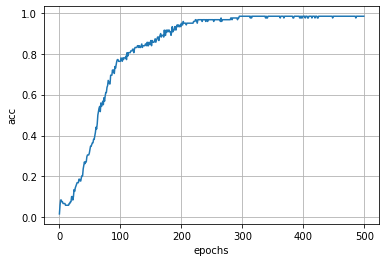

In [65]:
plt.plot(history.history['accuracy'])
plt.ylabel("acc")
plt.xlabel("epochs")
plt.grid(True)

In [66]:
seed_text = "Laurence went to dublin"
next_words = 10

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

    predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
    output_word = tokenizer.index_word[int(predicted)]
    
    seed_text += " " + output_word

print(seed_text)

Laurence went to dublin the nice girls and boys i might ask ask ask
